# JUST A BUNCH OF IMPORTS AND FUNCTIONS. 

# SCROLL DOWN TO 'START READING HERE'

In [2]:
import os
import collections
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics import r2_score

import scipy.sparse as sp

## DECOMPOSITION
from sklearn.decomposition import NMF
from scipy.linalg import svd

## NLP
import gensim
import re
import nltk
lemmatizer = nltk.stem.WordNetLemmatizer()
from nltk.corpus import stopwords
stopw = set(stopwords.words('english'))
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
def tknz(txt):
    return set(tokenizer.tokenize(re.sub("0|1|2|3|4|5|6|7|8|9|0", "", txt.lower())))-stopw


## GENERAL FUNCTIONS 
### NORMALIZATION
# Statistic normalization - subtract mean, scale by standard deviation
def norm_stat(vec, weights = False):
    '''
    Normalizes a vector v-v.mean())/v.std() 
    '''
    if weights:
        return  np.mean(abs(vec - vec.mean()))  
    return (vec-vec.mean())/vec.std()

# Algebraic normalization - dot product
def norm_dot(vec, weights = False):
    '''
    Normalizes the columns of a DataFrame (dot product)
    '''
    if weights:
        return  np.sqrt(vec @ vec)
    
    return vec / np.sqrt(vec @ vec)

# Algebraic normalization - dot product
def norm_sum(vec, weights = False):
    '''
    Normalizes the columns of a DataFrame (dot product)
    '''
    if weights:
        return  vec.sum()
    
    return vec / vec.sum()

# 
# Scaled Normalization -
def scale(vec, weights = False):
    stop_divide_by_zero = 0.00000001
    if weights:
        return (vec.max()-vec.min() + stop_divide_by_zero)
    return (vec-vec.min())/(vec.max()-vec.min() + stop_divide_by_zero)


    
# # MATRIX-FACTORIZATION: DIMENSIONALITY REDUCTION & ARCHETYPING

# ## CLUSTER FEATURES INTO OCCUPATION CATEGORIES
# ## Use non-zero matrix factorization for clustering
# ## Use singular value decomposition first state for determining overall similarity


class Archetypes:
    '''
    Archetypes: Performs NMF of order n on X and stores the result as attributes. 
    Archetypes are normalized: cosine similarity a(i) @ a(i) = 1. 
    Atributes:
        my_archetypes.n         - order / number of archetypes
        my_archetypes.X         - input matrix
        
        my_archetypes.model     - NMF model 
        my_archetypes.w         - NMF w-matrix 
        my_archetypes.h         - NMF h-matrix
        
        my_archetypes.o         - occupations x archetypes matrix (from w-matrix)
        my_archetypes.on        - occupations x normalized archetypes matrix (from w-matrix) - SOCP number as index. 
        my_archetypes.occ       - occupations x normalized archetypes matrix - Occupation names as index
        
        my_archetypes.f         - features x archetypes matrix (from h-matrix)
        my_archetypes.fn        - features x normalized archetypes matrix
        
    '''
    def __init__(self,X,n):
        self.n = n
        self.X = X
        self.model = NMF(n_components=n, init='random', random_state=0, max_iter = 1000, tol = 0.0000001)
        self.w = self.model.fit_transform(self.X)
        self.o = pd.DataFrame(self.w,index=self.X.index)
        #self.on = self.o.T.apply(norm).T
#         self.occ = self.on.copy()
#         self.occ['Occupations'] = self.occ.index
#        self.occ['Occupations'] = self.occ['Occupations'].apply(onet_socp_name)
#         self.occ = self.occ.set_index('Occupations')
        self.h = self.model.components_
        self.f = pd.DataFrame(self.h,columns=X.columns)
        #self.fn =self.f.T.apply(norm).T
#         self.plot_occupations_dic ={}
#         self.plot_features_dic ={}

class Svd:
    ''''
    Singular value decomposition-as-an-object
        my_svd = Svd(X) returns
        my_svd.u/.s/.vt – U S and VT from the Singular Value Decomposition (see manual)
        my_svd.f        – Pandas.DataFrame: f=original features x svd_features
        my_svd.o        - Pandas.DataFrame: o=occupations x svd_features
        my_svd.volume(keep_volume) 
                        - collections.namedtuple ('dotted dicionary'): 
                          Dimensionality reduction. keeps 'keep_volume' of total variance
                          
                          
    '''
    def __init__(self,X):
        self.u,self.s,self.vt = svd(np.array(X))
        self.f = pd.DataFrame(self.vt,columns=X.columns)
        self.o = pd.DataFrame(self.u,columns=X.index)
        
    def volume(self,keep_volume):
        ''' 
        Dimensionality reduction, keeps 'keep_volume' proportion of original variance
        Type: collections.namedtuple ('dotted dictionary')
        Examples of usage:
        my_svd.volume(0.9).s - np.array: eigenvalues for 90% variance 
        my_svd.volume(0.8).f - dataframe: features for 80% variance
        my_svd.volume(0.5).o - dataframe: occupations for 50% variance      
        '''
        dotted_dic = collections.namedtuple('dotted_dic', 's f o')
        a1 = self.s.cumsum()
        a2 = a1/a1[-1]
        n_max = np.argmin(np.square(a2 - keep_volume))
        cut_dic = dotted_dic(s= self.s[:n_max],f= self.f.iloc[:n_max], o= self.o.iloc[:n_max])
        return cut_dic
        

import nltk
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

def drop_stopwords(wordvec,language='English'):
    wv = np.array(wordvec)
    stw = np.array(stopwords.words(language))
    without_stopwords = wv[[not word in stw for word in wv]]
    return without_stopwords

# def lemmatize(wordvec):
#     return [lemmatizer.lemmatize(word,'v') for word in wordvec ]

def char_clean(string):
    string = string.lower()
    string = re.sub('\d',' ', string )
    string = re.sub('\W+',' ', string )
    string = re.sub(' [a-y] ',' ', string )
    return re.sub(' [a-y]{2} ',' ', string )

# def nlp_prep(string):
#     wordvec = char_clean(string).split()
#     return np.array(lemmatize(drop_stopwords(wordvec)))

def nlp_prep(string):
    return drop_stopwords(gensim.utils.simple_preprocess(string))

def multiply_counters(b,a):
    return Counter({k:a[k]*v for k,v in b.items()})

def rev_dict(dic):
    '''Reverse a dictionary'''
    return dict(zip(dic.values(),dic.keys()))

def indexate(seq,mirror=True):
    '''
    Create a lookup-table: Enumerate a sequence and return as a dictionary
    If mirror=True, make the lookup-table bi-directional. Requires that no elements of the sequence 
    overlap with the enumeration. 
    '''
    lst = list(seq)
    dic = dict(list(enumerate(lst,0)))
    if mirror:
        dic.update(rev_dict(dic))
    return dic

def keymap(f,dic):
    return {f(k):v for k,v in dic.items()}

def valuemap(f,dic):
    return {k:f(v) for k,v in dic.items()}

def keyvaluemap(f,g,dic):
    return {f(k):g(v) for k,v in dic.items()}

def identity(item): 
    return item

# START READING HERE

## IMPORT DICTATIONS. CLEAN AND LEMMATIZE. REMOVE NOISE.

In [3]:
# Create the word-vectors for the dictations
txt_files = !ls Documents/*.txt   #The names of dictation files in the 'Documents'-directory

raw_txt = {}
txt ={}
for file in txt_files:
    ix = file.replace('.txt','').replace('Documents/','')
    raw_txt[ix]=open(file).read()  
    txt[ix]=Counter(nlp_prep(raw_txt[ix]))
word_counts = sum(txt.values(),Counter())
word_weight = Counter({k: 1/v for k, v in word_counts.items()})

txt_w = {}
for key in txt.keys():
    txt_w[key] = multiply_counters(txt[key],word_weight)
    
# Create index of keys for txt and txt_w
tix = indexate(txt.keys())

# Create dict with index of words in corpus
wix = indexate(word_counts.keys())

## PUT CLEANED, LEMMATIZED DICTATIONS INTO A DATAFRAME 

In [4]:
wct = pd.Series(word_counts)
selected_words = wct[wct>=4].index.values
df = pd.SparseDataFrame(txt).T[selected_words].fillna(0)


## CREATE ONTOLOGY - 

## DESIGN CLUSTERING APPROACH

Text(0.5,0.98,'CLUSTERING DICTATIONS')

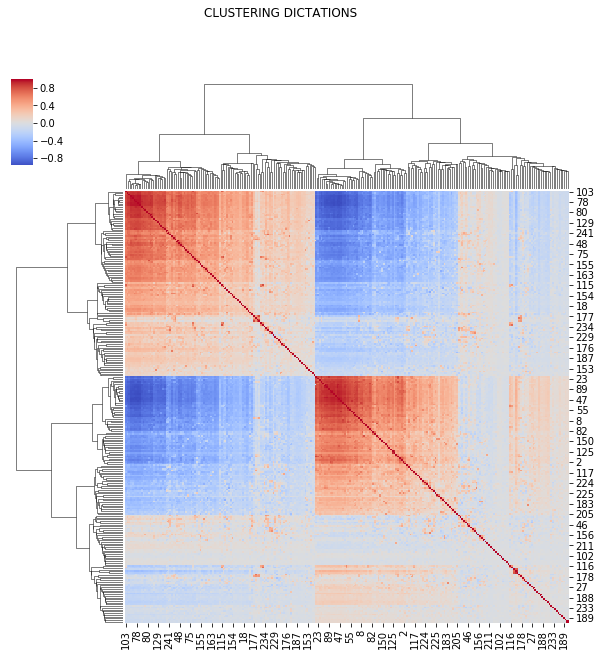

In [33]:
#### METHOD #####
# Build Ontology
#
# - df is the matrix of lemmatized dictations, represented by word-vectors. 
#       format: rows:dictations / columns: words. 
# A. Create orthogonal coordinate space
#    A.1 orb = orthogonal basis set: Eigenvectors of df. 'orb' is a Singular Value Decomposition object

orb = Svd(df)

# B. Built transformation matrices for projecting words/dictations between original space and the orthogonal space
#    B.1 orb.f = transforms Words (distribution vector across dictations) into orthogonal word-space
#    B.2 orb.o = transforms Dictations (word-vectors)into orthogonal dictation-space
#
# Clustering Method. Applies to Dictations and to Words- they are each others mirrors. 
# 1. Transform dictation or word vectors into orthogonal space. Normalize (dot-product =1)

dftr = (df @ orb.f[:100].T).T 
dftn = dftr.T.apply(norm_dot)

# 2. Calculate how much each vector deviates from average: 
#    Create differential vectors:  
#    2.a subtract the first eigenvector, this vector represents the average 'dictation' of 'word' in orthogonal space
#    2.b Renormalize the differentials (dot-product = 1)

dif = dftn.apply(lambda x: x - orb.o.iloc[0]).T.apply(norm_dot)

# 4. Calculate the similarity-matrix for the normalized differentials. 

simil = dif.T @ dif

# 5. Cluster the similarity-matrix - hierarchical clustering.  

sns.clustermap(simil.values,cmap = 'coolwarm').fig.suptitle('CLUSTERING DICTATIONS')

# JUST WORK-SPACE HERE BELOW

In [337]:
aaa = Svd(adf)

In [354]:
(aaa.f.T[0]+aaa.f.T[7]).sort_values(ascending = False)

surgical           0.082297
admitted           0.066616
age                0.065073
notable            0.054833
nausea             0.054485
home               0.054474
cough              0.050766
social             0.050390
constipation       0.050373
terazosin          0.049403
allergies          0.049378
metoprolol         0.048406
diarrhea           0.047965
gu                 0.047051
presentation       0.046702
dysuria            0.046331
shortness          0.045822
bladder            0.044988
bethanechol        0.044666
vomiting           0.043999
catheterization    0.043403
cell               0.043233
jaundice           0.042953
lisinopril         0.041977
hospital           0.041506
cancer             0.040800
twice              0.040380
diagnostic         0.040252
known              0.039954
city               0.039802
                     ...   
heart             -0.113306
cyanosis          -0.113546
post              -0.113573
respiratory       -0.113716
assessment        -0

In [312]:
df = pd.DataFrame(adjmat.todense())
df.index = df.index.map(txt_index)
df.columns = list(map(word_dic.get,df.columns))
aaa = Archetypes(df,10)

In [331]:
corr = (adjmat.T @ adjmat).todense()
df = pd.DataFrame(corr)
#df.index = df.index.map(txt_index)
df.index = df.index.map(word_dic)
df.columns = df.index

In [297]:
len(txt[txt_index[0]])

234